In [1]:
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

http://librosa.github.io/librosa/

In [2]:
y, sr = lr.load('generated_audio_files/tetrisA_mono.wav', sr=44100)
y_harmonic,y_percussive = lr.effects.hpss(y)
t = np.arange(len(y)) / sr

https://en.wikipedia.org/wiki/Constant-Q_transform

In [3]:
BANDS_PER_NOTE = 3;
n_bins = BANDS_PER_NOTE*88
bins_per_octave=12*BANDS_PER_NOTE
fmin= lr.midi_to_hz( 21 - (np.floor(BANDS_PER_NOTE/2)/BANDS_PER_NOTE) )

In [13]:
CQT = lr.cqt(y=y,bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
f = lr.cqt_frequencies(bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
midi_nn = np.arange(21,109, 1/BANDS_PER_NOTE);

https://en.wikipedia.org/wiki/Sound_pressure#Sound_pressure_level

In [14]:
SPL = 10* np.log10( np.real(CQT * np.conj(CQT)) )

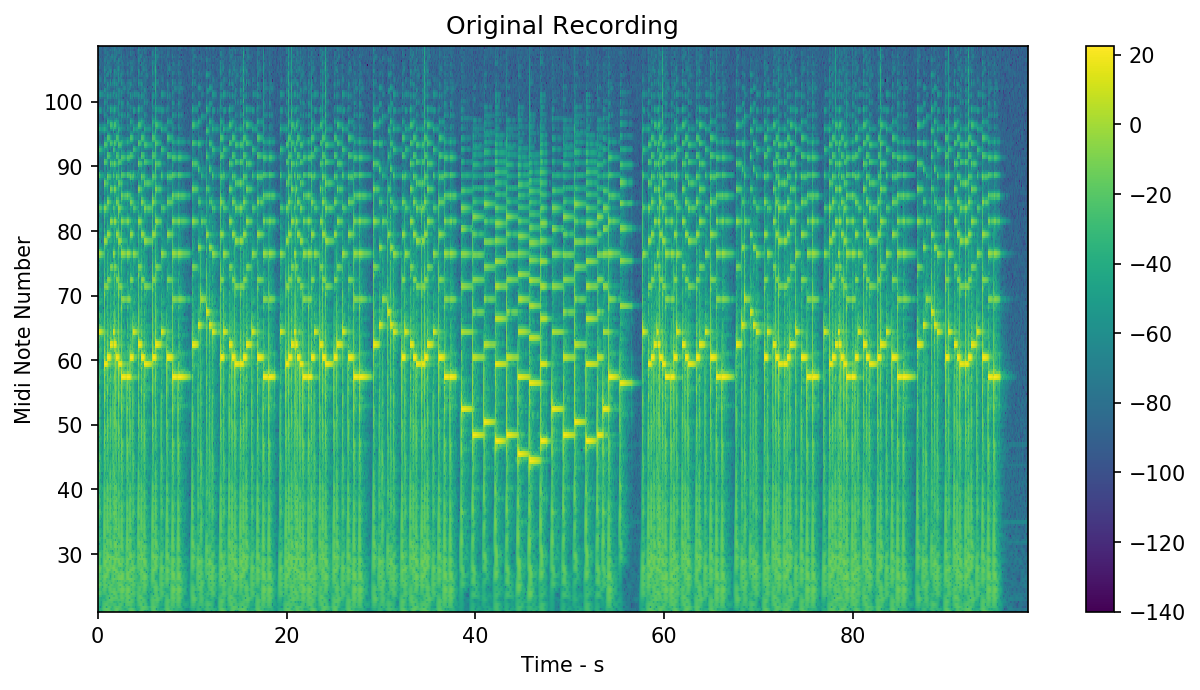

In [15]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Original Recording')
plt.colorbar()

#### Harmonic Component

In [16]:
CQT = lr.cqt(y=y_harmonic,bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
f = lr.cqt_frequencies(bins_per_octave=bins_per_octave, fmin=fmin, n_bins=n_bins)
midi_nn = np.arange(21,109, 1/BANDS_PER_NOTE);

In [17]:
SPL = 10* np.log10( np.real(CQT * np.conj(CQT)) )

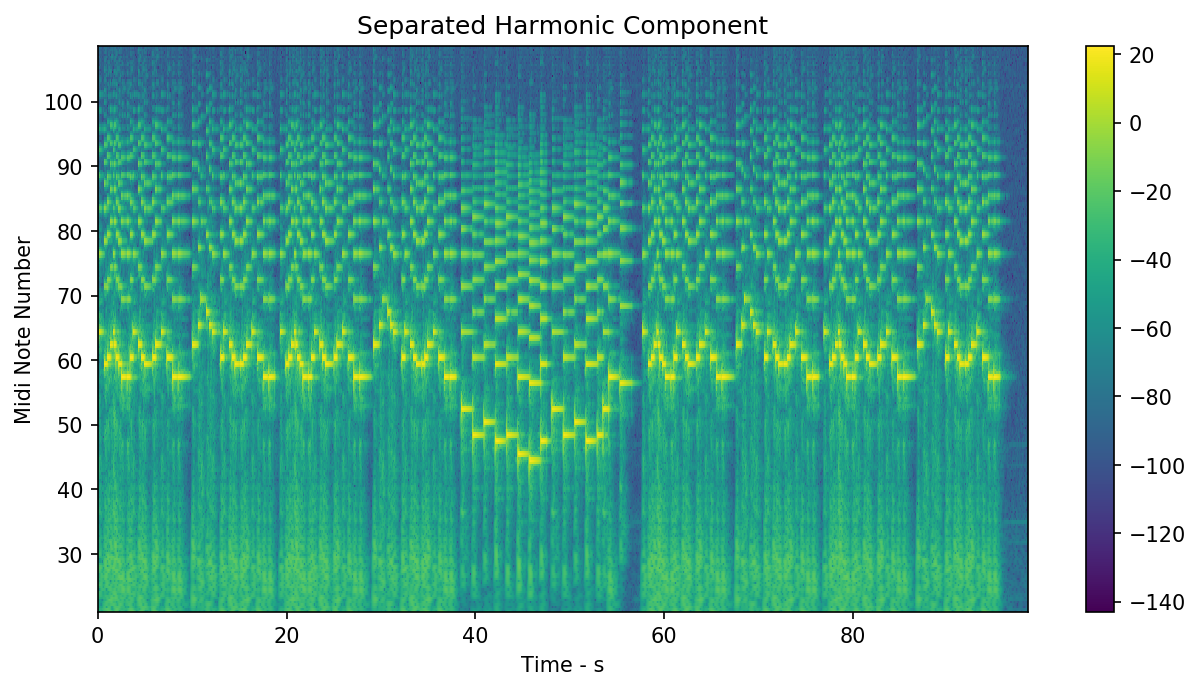

In [18]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Separated Harmonic Component')
plt.colorbar()

In [19]:
A_weight = np.tile(lr.A_weighting(f), [np.shape(SPL)[1],1]).T

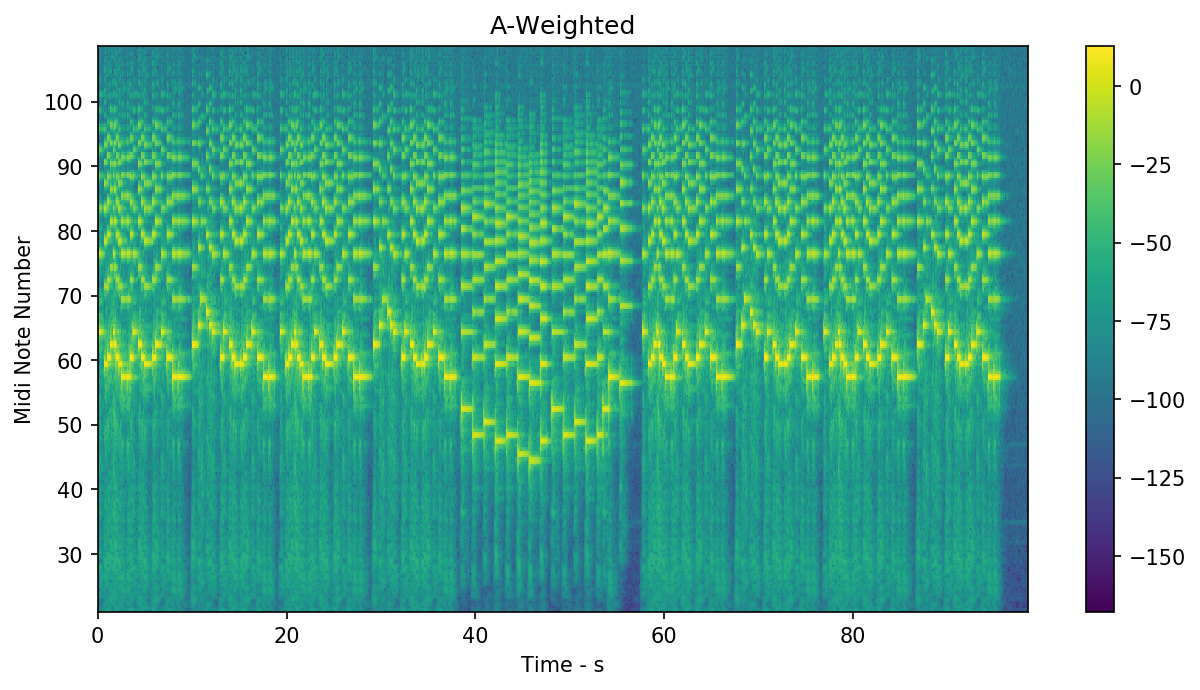

In [20]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL+A_weight, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('A-Weighted')
plt.colorbar()

In [21]:
def onset_impulse_response(BANDS_PER_NOTE, sigma, length):
    harmonics = np.array([0.0, 12.0, 19.0, 24.0, 28.0])
    harmonics = harmonics * BANDS_PER_NOTE
    center = np.max(harmonics)
    vert = np.zeros(int(2*center + 1))
    idx = (center + harmonics).astype('int')
    vert[idx] = 1
    penalty = np.array([0.0, 4.0, 9.0, 16.0]) * BANDS_PER_NOTE
    idx = penalty.astype('int')
    vert[idx] = -1
    window = sp.signal.gaussian(len(vert),len(vert) * 0.3)
#     vert = vert * window
    offset = np.arange(-center, center+1, 1)
    x = np.linspace(-np.pi, np.pi, length); 
#     [X,Y] = np.meshgrid(np.tanh(x), vert)
    [X,Y] = np.meshgrid(1, vert)
    midpt = int(np.shape(X)[0]/2);
    X[0:midpt,:] = 1
    H = X*Y
#     H = np.flipud(np.fliplr(X*Y))
    return H, offset

In [22]:
sigma = 0.3
length = 100
H,offset = onset_impulse_response(BANDS_PER_NOTE, sigma, length)

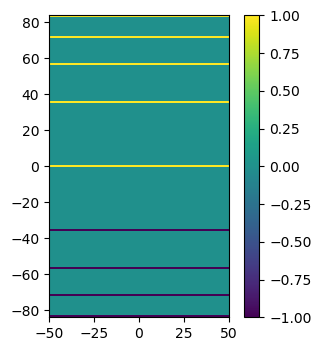

In [23]:
plt.figure(dpi = 100, figsize=(4,4))
extent=[-length/2, length/2, offset[0], offset[-1]]
plt.imshow(H,origin='lower', extent=extent)
plt.colorbar()

In [24]:
filtered = sp.ndimage.filters.correlate(SPL+A_weight, H)

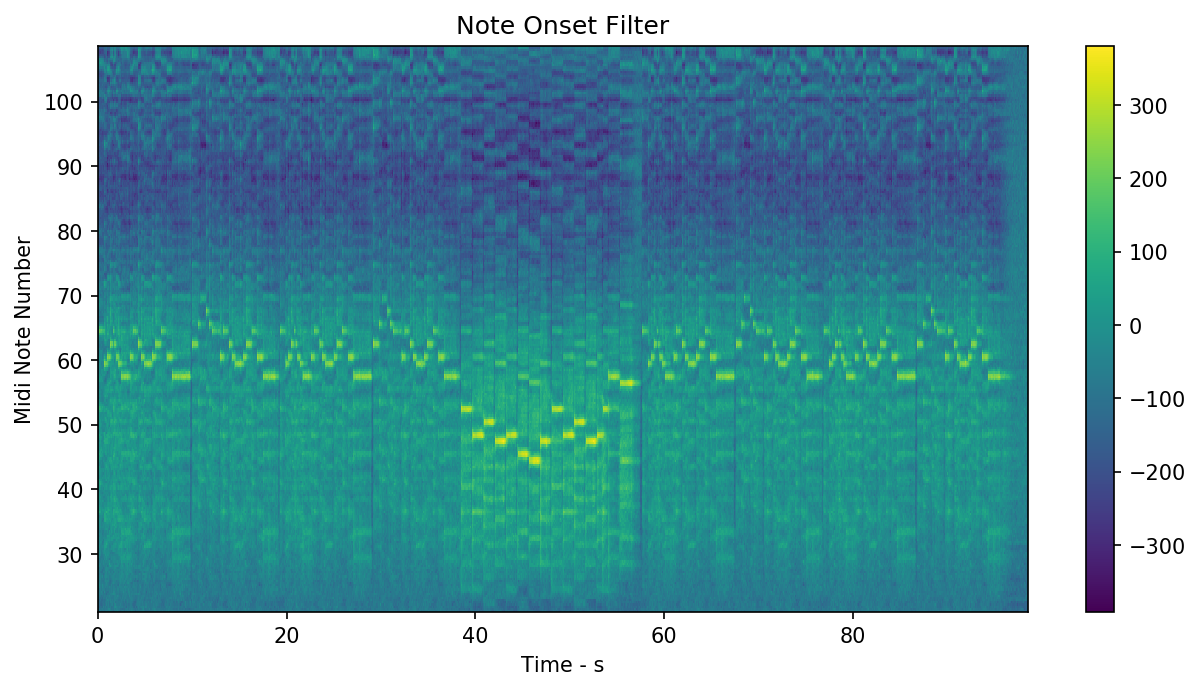

In [25]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(filtered, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Note Onset Filter')
plt.colorbar()

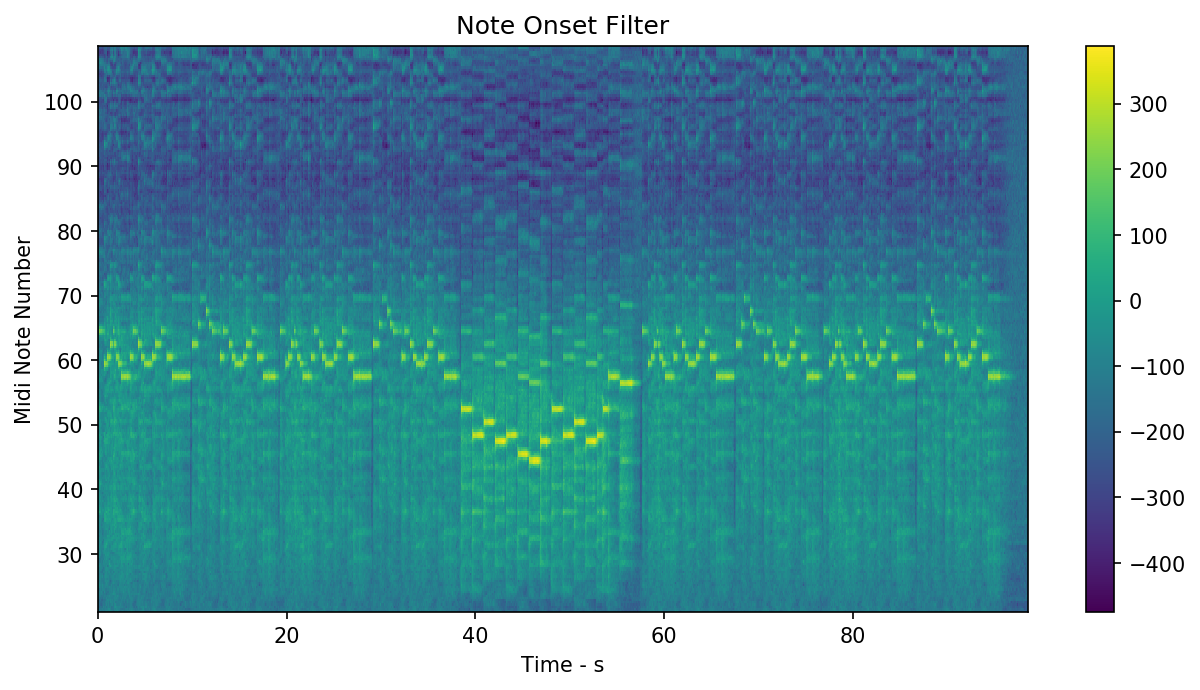

In [26]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(SPL+filtered, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Note Onset Filter')
plt.colorbar()

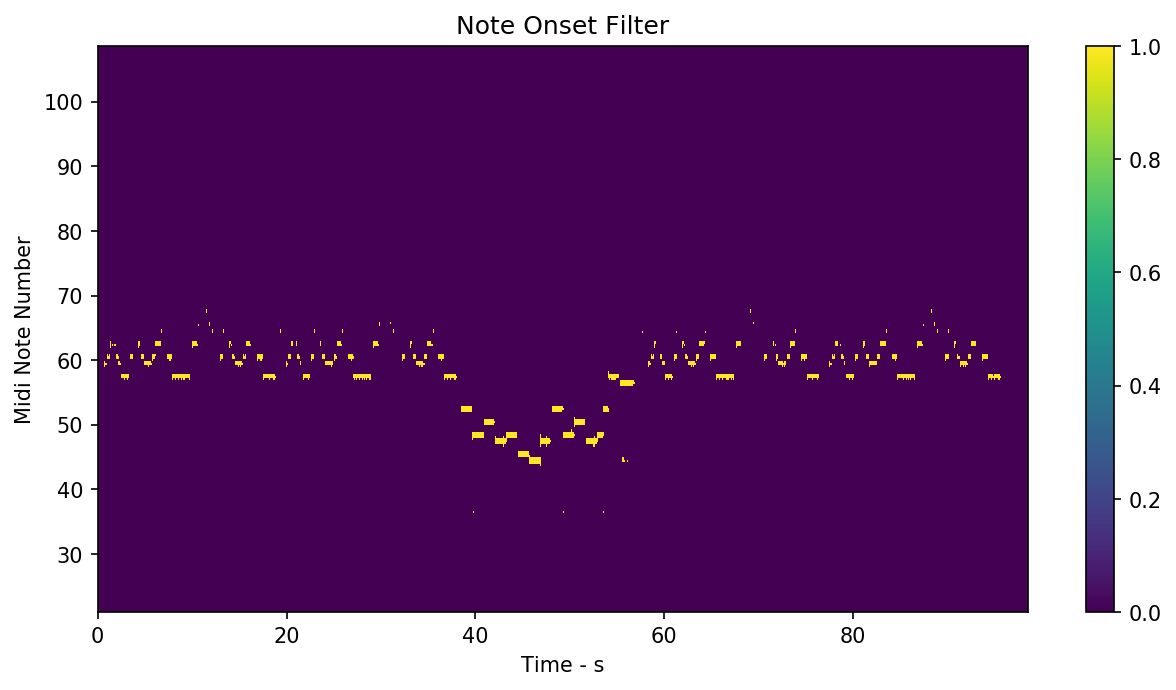

In [32]:
plt.figure(dpi = 150, figsize=(10,5))
extent=[t[0], t[-1], midi_nn[0], midi_nn[-1]]
plt.imshow(filtered>200, origin='lower', extent=extent, interpolation='none', aspect='auto')
plt.xlabel('Time - s')
plt.ylabel('Midi Note Number')
plt.title('Note Onset Filter')
plt.colorbar()